# Speech Emotion Recognition - Time Distributed ConvNet


In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


## I. Context
In this project I build a prevision model using deep learning combining **CNN**  and  **LSTM**  to detect a person’s emotions (HAPPY, SAD, FEAR, ANGRY, DISGUST, SURPRISE, NEUTRAL) just by their voice. 

### Audio features:
- **Log-mel-spectrogram**: the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency


### Data:
- **RAVDESS**: The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes *calm*, *happy*, *sad*, *angry*, *fearful*, *surprise*, and *disgust* expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. (https://zenodo.org/record/1188976#.XA48aC17Q1J)

## II. General Imports

In [2]:
### General imports ###
import os
from glob import glob
import pickle
import numpy as np

### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## III. Import datas

In [4]:
# RAVDESS mel-Spectrogram
X_train = pickle.load(open('../Data/Pickle/[RAVDESS][MEL_SPECT][X_train].p', 'rb'))
y_train = pickle.load(open('../Data/Pickle/[RAVDESS][MEL_SPECT][y_train].p', 'rb'))
y_test = pickle.load(open('../Data/Pickle/[RAVDESS][MEL_SPECT][y_test].p', 'rb'))
X_test = pickle.load(open('../Data/Pickle/[RAVDESS][MEL_SPECT][X_test].p', 'rb'))

## IV. Encode label

In [5]:
# Encode Label from categorical to numerical
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

In [6]:
y_test.shape

(269, 7)

## V. Reshape train and test set

In [7]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

In [8]:
X_train.shape

(3225, 5, 128, 128, 1)

## VI. Time Distributed ConvNet model
https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

In [9]:
K.clear_session()

# Define two sets of inputs: MFCC and FBANK
input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                      
                               
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)

# Plot model graph
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
# Image(retina=True, filename='model.png')

In [17]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('../Datas/Pickle/RAVDESS/DIS/[CNN-LSTM]Model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Epoch 1/100
202/202 [==============================] - 26s 119ms/step - loss: 1.6255 - accuracy: 0.3423 - val_loss: 1.5698 - val_accuracy: 0.3123
Epoch 2/100
202/202 [==============================] - 24s 120ms/step - loss: 1.5608 - accuracy: 0.3789 - val_loss: 1.5992 - val_accuracy: 0.3680
Epoch 3/100
202/202 [==============================] - 24s 119ms/step - loss: 1.4910 - accuracy: 0.4019 - val_loss: 1.4403 - val_accuracy: 0.4164
Epoch 4/100
202/202 [==============================] - 24s 117ms/step - loss: 1.4089 - accuracy: 0.4496 - val_loss: 1.5089 - val_accuracy: 0.4535
Epoch 5/100
202/202 [==============================] - 23s 116ms/step - loss: 1.3649 - accuracy: 0.4608 - val_loss: 1.4170 - val_accuracy: 0.4164
Epoch 6/100
202/202 [==============================] - 24s 120ms/step - loss: 1.2841 - accuracy: 0.4992 - val_loss: 1.5086 - val_accuracy: 0.4201
Epoch 7/100
202/202 [==============================] - 26s 129ms/step - loss: 1.2202 - accuracy: 0.5309 - val_loss: 1.8045 -

Epoch 19/100
202/202 [==============================] - 25s 122ms/step - loss: 0.7854 - accuracy: 0.7002 - val_loss: 1.3253 - val_accuracy: 0.5576
Epoch 20/100
202/202 [==============================] - 24s 117ms/step - loss: 0.7023 - accuracy: 0.7371 - val_loss: 1.3938 - val_accuracy: 0.5465
Epoch 21/100
202/202 [==============================] - 24s 118ms/step - loss: 0.7102 - accuracy: 0.7395 - val_loss: 1.0896 - val_accuracy: 0.6171
Epoch 22/100
202/202 [==============================] - 24s 117ms/step - loss: 0.6981 - accuracy: 0.7460 - val_loss: 1.8242 - val_accuracy: 0.4312
Epoch 23/100
202/202 [==============================] - 24s 117ms/step - loss: 0.6560 - accuracy: 0.7519 - val_loss: 1.6354 - val_accuracy: 0.4758
Epoch 24/100
202/202 [==============================] - 24s 118ms/step - loss: 0.6268 - accuracy: 0.7668 - val_loss: 1.0636 - val_accuracy: 0.6357
Epoch 25/100
202/202 [==============================] - 25s 125ms/step - loss: 0.6093 - accuracy: 0.7693 - val_loss: 1

Epoch 37/100
202/202 [==============================] - 26s 127ms/step - loss: 0.3195 - accuracy: 0.8840 - val_loss: 1.1578 - val_accuracy: 0.6691
Epoch 38/100
202/202 [==============================] - 25s 125ms/step - loss: 0.3059 - accuracy: 0.8905 - val_loss: 1.4861 - val_accuracy: 0.5762
Epoch 39/100
202/202 [==============================] - 25s 123ms/step - loss: 0.2993 - accuracy: 0.8865 - val_loss: 1.2873 - val_accuracy: 0.6245
Epoch 40/100
202/202 [==============================] - 26s 127ms/step - loss: 0.2751 - accuracy: 0.8980 - val_loss: 1.4027 - val_accuracy: 0.6245
Epoch 41/100
202/202 [==============================] - 25s 124ms/step - loss: 0.2739 - accuracy: 0.8924 - val_loss: 0.9940 - val_accuracy: 0.7063
Epoch 42/100
202/202 [==============================] - 25s 123ms/step - loss: 0.2328 - accuracy: 0.9150 - val_loss: 1.6517 - val_accuracy: 0.5836
Epoch 43/100
202/202 [==============================] - 25s 123ms/step - loss: 0.2341 - accuracy: 0.9144 - val_loss: 1

Epoch 55/100
202/202 [==============================] - 24s 121ms/step - loss: 0.0957 - accuracy: 0.9690 - val_loss: 1.3499 - val_accuracy: 0.7212
Epoch 56/100
202/202 [==============================] - 25s 124ms/step - loss: 0.0868 - accuracy: 0.9730 - val_loss: 1.5571 - val_accuracy: 0.6394
Epoch 57/100
202/202 [==============================] - 24s 119ms/step - loss: 0.0870 - accuracy: 0.9712 - val_loss: 1.2424 - val_accuracy: 0.6989
Epoch 58/100
202/202 [==============================] - 24s 119ms/step - loss: 0.0926 - accuracy: 0.9678 - val_loss: 2.3316 - val_accuracy: 0.5911
Epoch 59/100
202/202 [==============================] - 24s 119ms/step - loss: 0.0821 - accuracy: 0.9733 - val_loss: 1.8665 - val_accuracy: 0.6097
Epoch 60/100
202/202 [==============================] - 24s 120ms/step - loss: 0.0786 - accuracy: 0.9736 - val_loss: 1.4031 - val_accuracy: 0.7212
Epoch 61/100
202/202 [==============================] - 25s 124ms/step - loss: 0.0799 - accuracy: 0.9752 - val_loss: 1

Epoch 73/100
202/202 [==============================] - 29s 145ms/step - loss: 0.0367 - accuracy: 0.9901 - val_loss: 1.9180 - val_accuracy: 0.6468
Epoch 74/100
202/202 [==============================] - 27s 132ms/step - loss: 0.0449 - accuracy: 0.9848 - val_loss: 1.1857 - val_accuracy: 0.7509
Epoch 75/100
202/202 [==============================] - 31s 151ms/step - loss: 0.0343 - accuracy: 0.9879 - val_loss: 1.4252 - val_accuracy: 0.7138
Epoch 76/100
202/202 [==============================] - 28s 138ms/step - loss: 0.0341 - accuracy: 0.9904 - val_loss: 1.1452 - val_accuracy: 0.7398
Epoch 77/100
202/202 [==============================] - 26s 127ms/step - loss: 0.0322 - accuracy: 0.9885 - val_loss: 1.4133 - val_accuracy: 0.6914
Epoch 78/100
202/202 [==============================] - 26s 128ms/step - loss: 0.0325 - accuracy: 0.9895 - val_loss: 1.1783 - val_accuracy: 0.7435
Epoch 79/100
202/202 [==============================] - 25s 123ms/step - loss: 0.0248 - accuracy: 0.9938 - val_loss: 1

Epoch 91/100
202/202 [==============================] - 26s 129ms/step - loss: 0.0217 - accuracy: 0.9926 - val_loss: 1.3659 - val_accuracy: 0.7286
Epoch 92/100
202/202 [==============================] - 26s 127ms/step - loss: 0.0167 - accuracy: 0.9941 - val_loss: 1.4322 - val_accuracy: 0.7509
Epoch 93/100
202/202 [==============================] - 25s 124ms/step - loss: 0.0162 - accuracy: 0.9960 - val_loss: 1.1598 - val_accuracy: 0.7881
Epoch 94/100
202/202 [==============================] - 26s 128ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 1.5896 - val_accuracy: 0.6766
Epoch 95/100
202/202 [==============================] - 25s 126ms/step - loss: 0.0201 - accuracy: 0.9929 - val_loss: 1.7672 - val_accuracy: 0.7026
Epoch 96/100
202/202 [==============================] - 26s 127ms/step - loss: 0.0198 - accuracy: 0.9944 - val_loss: 1.3053 - val_accuracy: 0.7509
Epoch 97/100
202/202 [==============================] - 25s 123ms/step - loss: 0.0202 - accuracy: 0.9932 - val_loss: 1

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


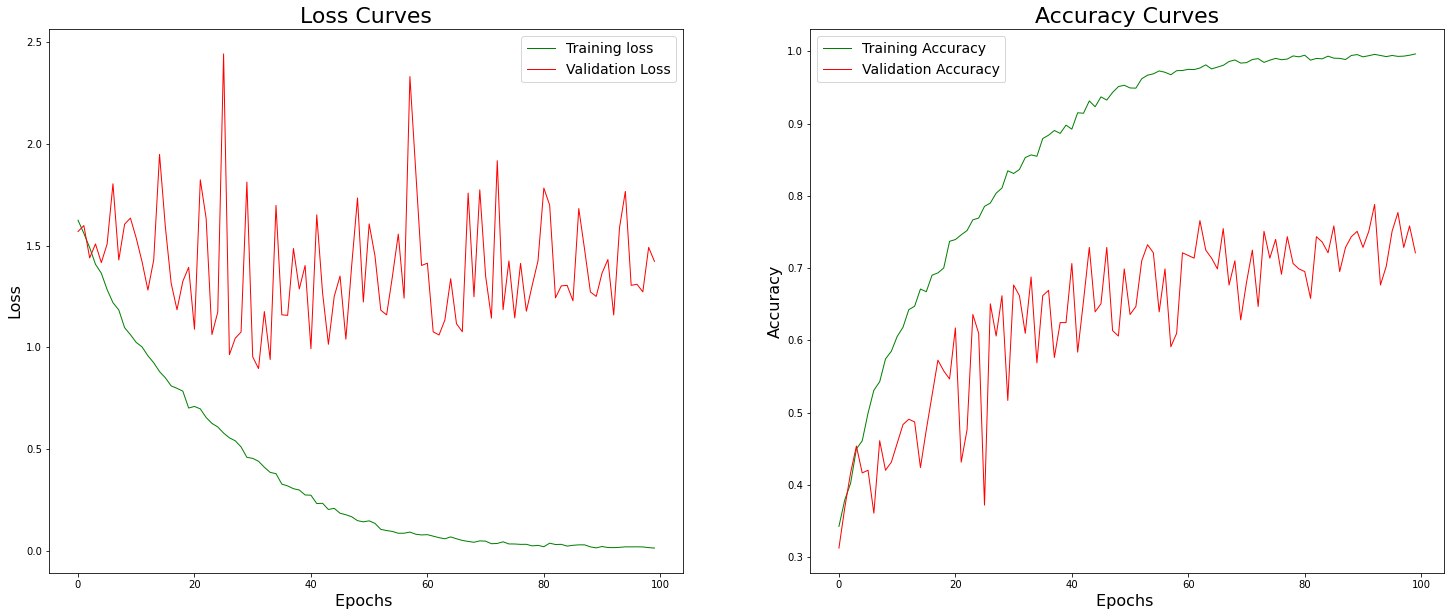

In [28]:
# Loss Curves
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],'-g',linewidth=1.0)
plt.plot(history.history['val_loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=22)
 
# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],'-g',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=22)
plt.show()

## VII. Save model

In [29]:
model.save('../Data/Model/[CNN-LSTM]M.h5')
model.save_weights('../Data/Model/[CNN-LSTM]W.h5')

## VIII. Test model

In [12]:
model.load_weights("../Data/Model/[CNN-LSTM]W.h5")

In [13]:
y_predict = model.predict(X_test)

In [18]:
np.argmax(y_test[0])

5

In [16]:
np.argmax(y_predict[0])

5

In [24]:
test_class_predict = [np.argmax(y_predicted) for y_predicted in y_predict]
class_predict = [np.argmax(y_actual) for y_actual in y_test]

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [29]:
cm = confusion_matrix(class_predict, test_class_predict)

In [31]:
cm

array([[36,  0,  0,  0,  0,  0,  0],
       [ 0, 40,  0,  0,  0,  0,  0],
       [ 0,  0, 35,  0,  0,  1,  4],
       [ 0,  0,  0, 36,  0,  0,  1],
       [ 0,  1,  0,  0, 41,  0,  0],
       [ 0,  0,  1,  0,  1, 37,  1],
       [ 0,  0,  0,  1,  0,  0, 33]], dtype=int64)

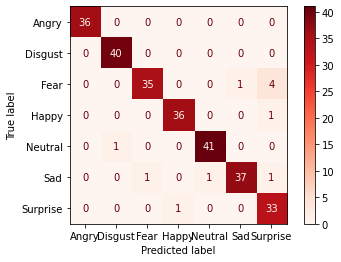

In [32]:
labels = ['Angry','Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Reds)
plt.show()